# Estimate Sentiment

## Get the bert model reop
1. Contains the model
2. Containg the model trainer

In [93]:
!git clone https://github.com/wzwzeyal/bert_classifier_repo.git
!gdown --id 1pjsSVpOpbCk7ce8ZppbEqk8DjGK4q1Sf
!pip install transformers
!git clone https://github.com/wzwzeyal/ojt_bert

fatal: destination path 'bert_classifier_repo' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1pjsSVpOpbCk7ce8ZppbEqk8DjGK4q1Sf
To: /content/bert_token.pt
100% 438M/438M [00:05<00:00, 81.4MB/s]
fatal: destination path 'ojt_bert' already exists and is not an empty directory.


In [94]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bert_classifier_repo.module import BertClassifierModule

## The sentiment would be prediceted using
1. finetuned bert model
2. pretrained bert model

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## finetuned bert model

The model was fintuned in colab gpu using the notebook
*finetune_bert_gpu.ipynb*

In [96]:
bert_model_name = 'avichr/heBERT_sentiment_analysis'

state_dict = torch.load('bert_token.pt', map_location=device)

model = BertClassifierModule(bert_model_name)

model.load_state_dict(state_dict)

Some weights of the model checkpoint at avichr/heBERT_sentiment_analysis were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [97]:
import transformers
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)
max_len = 130

In [98]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,#text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length= max_len,                  # Max length to truncate/pad
            #  The `pad_to_max_length` argument is deprecated and will be removed in a future version, 
            # use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, 
            # or use `padding='max_length'` to pad to a max length. 
            # In this case, you can give a specific length with `max_length` 
            # (e.g. `max_length=45`) or leave max_length to None to 
            # pad to the maximal input size of the model (e.g. 512 for Bert).

            # pad_to_max_length=True,         # Pad sentence to max length
            padding='max_length',
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks 

In [99]:
ROOT_PATH = 'ojt_bert/data/for_sentiment'

X_val = pd.read_csv(f'{ROOT_PATH}/val_token_df.gz')

val_inputs, val_masks = preprocessing_for_bert(list(X_val.comment_clean.values))

In [102]:
model.to(device);

In [103]:
def predict(comments):
  with torch.no_grad():
    val_inputs, val_masks = preprocessing_for_bert(comments)
    val_inputs = val_inputs.to(device)
    val_masks = val_masks.to(device)
    model.eval()
    outputs = model(val_inputs, val_masks)
    results = torch.argmax(outputs, dim=1)
    return results.cpu().numpy()

In [104]:
X_val['finetune'] = predict(X_val.comment_clean)

In [105]:
X_val.head()

,Unnamed: 0,comment,label,comment_clean,sentiment,comment_clean_len,finetune
0,0,מתבייש בך שאתה הנשיא שלי . חשבתי שיש בך קצת יו...,1,מתבייש בך שאתה הנשיא שלי חשבתי שיש בך קצת יותר...,neg,72,1
1,1,מזל טוב לעם ישראל שהנשיא העשירי שנבחר הוא ראוב...,0,מזל טוב לעם ישראל שהנשיא העשירי שנבחר הוא ראוב...,pos,94,0
2,2,מקסים 😊,0,מקסים,pos,5,0
3,4,דניאל כך הכבוד,2,דניאל כך הכבוד,nut,14,0
4,5,אחלה נשיא רובי ....,0,אחלה נשיא רובי,pos,14,0


## pretrained bert model

In [106]:
from transformers import AutoTokenizer, AutoModel, pipeline
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis") #same as 'avichr/heBERT' tokenizer
model = AutoModel.from_pretrained("avichr/heBERT_sentiment_analysis")

# how to use?
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="avichr/heBERT_sentiment_analysis",
    tokenizer="avichr/heBERT_sentiment_analysis",
    return_all_scores = False)

Some weights of the model checkpoint at avichr/heBERT_sentiment_analysis were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
df = pd.DataFrame(sentiment_analysis(list(X_val.comment_clean)))
codes = {'positive' : 0, 'negative': 1, 'neutral' : 2}
X_val['pretrain'] = df['label'].map(codes)

## Finetuned and pretrained comparison

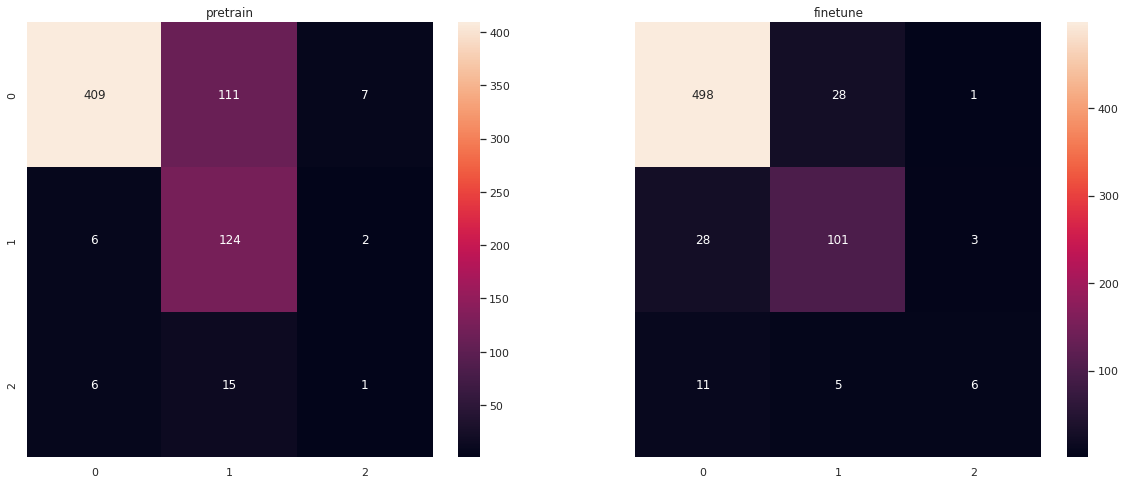

In [119]:
sns.set(rc={'figure.figsize':(20,8)})

fig, axs = plt.subplots(1,2)

axs[0].set_title('pretrain')
sns.heatmap(confusion_matrix(X_val.label, X_val.pretrain), annot=True, ax=axs[0], fmt='g')

axs[1].set_title('finetune')
sns.heatmap(confusion_matrix(X_val.label, X_val.finetune), annot=True, ax=axs[1], fmt='g')

In [1]:
from transformers import BertModel, BertTokenizerFast

alephbert_tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
alephbert = BertModel.from_pretrained('onlplab/alephbert-base')

# if not finetuning - disable dropout
alephbert.eval()

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(52000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          